In [21]:
import torch
import numpy as np
import os

import gpt as g
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.dirac import dirac_wilson_clover

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

In [22]:
class Smoother_PTC(torch.nn.Module):
    def __init__(self, U):
        super().__init__()
        self.U = U
        self.paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
        self.l0 = v_PTC(2, 2, self.paths, self.U)
        self.l1 = v_PTC(2, 2, self.paths, self.U)
        self.l2 = v_PTC(2, 2, self.paths, self.U)
        self.l3 = v_PTC(2, 1, self.paths, self.U)

    def forward(self, v):
        for l in [self.l0, self.l1, self.l2, self.l3]:
            v = l.forward(v)
        return v

In [23]:
vec = torch.complex(
        torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
        , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))


In [24]:
Smoother_PTC(U).forward(torch.stack([vec,vec])).shape

torch.Size([1, 8, 8, 8, 16, 4, 3])

In [25]:

def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()


def l2norm(v):
    return (v * v.conj()).real.sum()

In [33]:
def lattice2ndarray(lattice):
    """ 
    Converts a gpt (https://github.com/lehner/gpt) lattice to a numpy ndarray 
    keeping the ordering of axes as one would expect.
    Example::
        q_top = g.qcd.gauge.topological_charge_5LI(U_smeared, field=True)
        plot_scalar_field(lattice2ndarray(q_top))
    """
    shape = lattice.grid.fdimensions
    shape = list(reversed(shape))
    if lattice[:].shape[1:] != (1,):
        shape.extend(lattice[:].shape[1:])
   
    result = lattice[:].reshape(shape)
    result = np.swapaxes(result, 0, 3)
    result = np.swapaxes(result, 1, 2)
    return result

def ndarray2lattice(ndarray, grid, lat_constructor):
    """
    Converts an ndarray to a gpt lattice, it is the inverse 
    of lattice2ndarray.

    Example::
        lat = ndarray2lattice(arr, g.grid([4,4,4,8], g.double), g.vspincolor)
    """
    lat = lat_constructor(grid)
    data = np.swapaxes(ndarray, 0, 3)
    data = np.swapaxes(data, 1, 2)
    lat[:] = data.reshape([data.shape[0] * data.shape[1] * data.shape[2] * data.shape[3]] + list(data.shape[4:]))
    return lat

In [34]:
weights_ptc1h1l = torch.load("ptc1h1l_start_id.pt")[0]

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.55,
    "csw_r": 0.0,
    "csw_t": 0.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))


GPT :      77.184810 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :      77.194076 s : Switching view to [1,1,1,1]/Read
GPT :      77.221758 s : Read 0.00109863 GB at 0.0395835 GB/s (0.357348 GB/s for distribution, 0.0445269 GB/s for reading + checksum, 3.23368 GB/s for checksum, 1 views per node)
GPT :      77.234361 s : Read 0.00109863 GB at 0.0915448 GB/s (2.78429 GB/s for distribution, 0.0946823 GB/s for reading + checksum, 2.94441 GB/s for checksum, 1 views per node)
GPT :      77.246972 s : Read 0.00109863 GB at 0.0904221 GB/s (4.05991 GB/s for distribution, 0.0925041 GB/s for reading + checksum, 3.54462 GB/s for checksum, 1 views per node)
GPT :      77.258526 s : Read 0.00109863 GB at 0.0985837 GB/s (4.13274 GB/s for distribution, 0.101019 GB/s for reading + checksum, 3.92839 GB/s for checksum, 1 views per node)
GPT :      77.259798 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.076699 s


In [35]:
paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
ptc_layer = v_PTC(1, 1, paths, U)
ptc_layer.weights = torch.nn.Parameter(weights_ptc1h1l, requires_grad=False)


In [36]:
def iterative_uk(ukm1, b, Mh, D):
    result = b
    result = result - D(ukm1)
    result = Mh(result)
    result = ukm1 + result
    return result

def ukn(b, Mh, D, n):
    uk = torch.zeros_like(b)
    
    for k in range(n):
        uk = iterative_uk(uk, b, Mh, D)
    return uk


In [37]:
layer = Smoother_PTC(U)

In [38]:
idty = torch.complex(torch.tensor(np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))
zeros = torch.complex(torch.zeros((4,4), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))

for li in (layer.l0, layer.l1, layer.l2, layer.l3):
    li.weights.data[:,:,:] = zeros
    li.weights.data[:,:,0] = idty

In [39]:
def GMRES_torch(A, b, x0, maxiter=1000, eps=1e-4
              , innerproduct=None
              , prec=None):
    """
    GMRES solver.
    
    innerproduct is a function (vec,vec)->scalar which is a product.
    prec is a function vec->vec.

    Literature:
    - https://en.wikipedia.org/wiki/Generalized_minimal_residual_method
    - https://www-users.cse.umn.edu/~saad/Calais/PREC.pdf

    Authors:
    - Daniel Knüttel 2024
    """
    if hasattr(A, "__call__"):
        apply_A = lambda x: A(x)
    else:
        apply_A = lambda x: A @ x

    if innerproduct is None:
        innerproduct = lambda x,y: (x.conj() * y).sum()

    
    rk = b - apply_A(x0)

    b_norm = np.sqrt(innerproduct(b, b).real)
    
    rk_norm = np.sqrt(innerproduct(rk, rk).real)
    if rk_norm <= eps:
        return x0, {"converged": True, "k": 0}

    vk = rk / rk_norm

    v = [None, vk]
    
    cs = np.zeros(maxiter + 2, np.complex128)
    sn = np.zeros(maxiter + 2, np.complex128)
    gamma = np.zeros(maxiter + 2, np.complex128)
    gamma[1] = rk_norm
    H = [None]
    
    converged = False
    for k in range(1, maxiter + 1):
        if prec is not None:
            z = prec(v[k])
        else:
            z = v[k]
        qk = apply_A(z)
        
        Hk = np.zeros(k + 2, np.complex128)
        for i in range(1, k + 1):
            Hk[i] = innerproduct(v[i], qk)
        for i in range(1, k + 1):
            qk -= Hk[i] * v[i]
            
        Hk[k+1] = np.sqrt(innerproduct(qk, qk).real)
        v.append(qk / Hk[k+1])

        for i in range(1, k):
            # (c   s ) [a]   [a']
            # (-s* c*) [b] = [b']
            tmp = cs[i+1] * Hk[i] + sn[i+1] * Hk[i+1]
            Hk[i+1] = -np.conj(sn[i+1]) * Hk[i] + np.conj(cs[i+1]) * Hk[i+1]
            Hk[i] = tmp
            

        beta = np.sqrt(np.abs(Hk[k])**2 + np.abs(Hk[k + 1])**2)

        # ( c    s )[a]   [X]
        # (-s*   c*)[b] = [0]
        # is solved by 
        # s* = b; c* = a
        sn[k+1] = np.conj(Hk[k+1]) / beta
        cs[k+1] = np.conj(Hk[k]) / beta
        Hk[k] = cs[k+1] * Hk[k] + sn[k+1] * Hk[k+1]
        Hk[k+1] = 0
        
        
        gamma[k+1] = -np.conj(sn[k+1]) * gamma[k]
        gamma[k] = cs[k+1] * gamma[k]
        
        H.append(Hk)
        if np.abs(gamma[k+1]) / b_norm <= eps:
            converged = True
            break

    y = np.zeros(k+1, np.complex128)
    for i in reversed(range(1, k + 1)):
        overlap = 0
        for j in range(i+1, k+1):
            overlap += H[j][i] * y[j]
        y[i] = (gamma[i] - overlap) / H[i][i]
    if prec is None:
        x = x0 + sum(yi * vi for yi, vi in zip(y[1:], v[1:]))
    else:
        x = x0 + sum(yi * prec(vi) for yi, vi in zip(y[1:], v[1:]))
    return x, {"converged": converged, "k": k}

In [41]:
vec = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

x, ret = GMRES_torch(w, vec, vec, eps=1e-6, maxiter=500)
ret

{'converged': True, 'k': 92}

In [42]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)
zero = torch.zeros_like(vec)

n_training = 1000
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    vec = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

    outp = torch.stack([
        ukn(vec, lambda x: ptc_layer.forward(torch.stack([x]))[0], w, 0+2)
    ])
    inp = torch.stack([
        vec, ukn(vec, lambda x: ptc_layer.forward(torch.stack([x]))[0], w, 0+0)
    ])

    scale = l2norm(inp[0])
    inp = inp / scale
    outp = outp / scale
    
    score = complex_mse_loss(layer.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_torch(w, vec, vec, prec=lambda v: layer.forward(torch.stack([v, vec]))[0], eps=1e-4, maxiter=500)
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")

IndexError: index 1000 is out of bounds for axis 0 with size 1000

Text(0, 0.5, 'iterations required by GMRES')

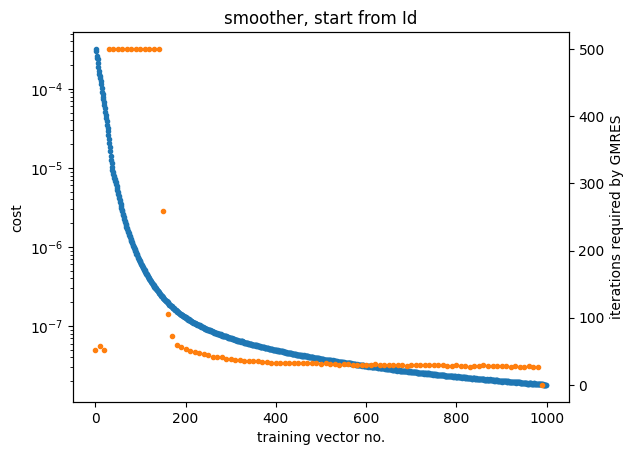

In [43]:
plt.plot(loss, ".")
plt.title("smoother, start from Id")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")

In [ ]:
zero = torch.zeros_like(vec)
with torch.no_grad():
    x_p, ret_p = GMRES_torch(w, vec, vec, prec=lambda v: layer.forward(torch.stack([v, zero]))[0], eps=1e-6)

In [44]:
ret["k"], ret_p["k"]

(92, 27)

In [45]:
torch.save(list(layer.parameters()), "smoother_start_id.pt")
